<a href="https://colab.research.google.com/github/gub4rk/DS4002_CS3/blob/main/CODE/HurricaneAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This code is what you require to replicate the study on predicting hurricane activity

# Importing Libraries and The Dataset is the first step

In [2]:
! git clone https://github.com/gub4rk/DS4002_CS3 # allows you to import data from the GitHub

Cloning into 'DS4002_CS3'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 59.33 KiB | 867.00 KiB/s, done.


In [5]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

# read in data
data = pd.read_csv("/content/DS4002_CS3/DATA/Hurricane_Dataset.csv", index_col='Year')

# get rid of unneeded columns and take look at data
data = data[data.columns[2:]]
data.head()

,Total_Hurricane_Days,CO2_emissions,Population,CSIRO_Adjusted_SeaLevel_Inch,Surface_Temperature_Change,SurfaceSeaTemp_Annual_Anomaly
Year,,,,,,
1971,67.25,1.550279e+10,3769847834,4.881890,-0.093,-0.519
1972,40.00,1.622344e+10,3844917687,5.240157,-0.199,-0.193
1973,38.50,1.708350e+10,3920805030,5.003937,0.269,-0.151
1974,37.00,1.700938e+10,3996416108,5.472441,-0.181,-0.427
1975,47.25,1.704998e+10,4070735264,5.409449,0.088,-0.445


# Next, we will conduct visualizations so you can familiarize yourself with the data

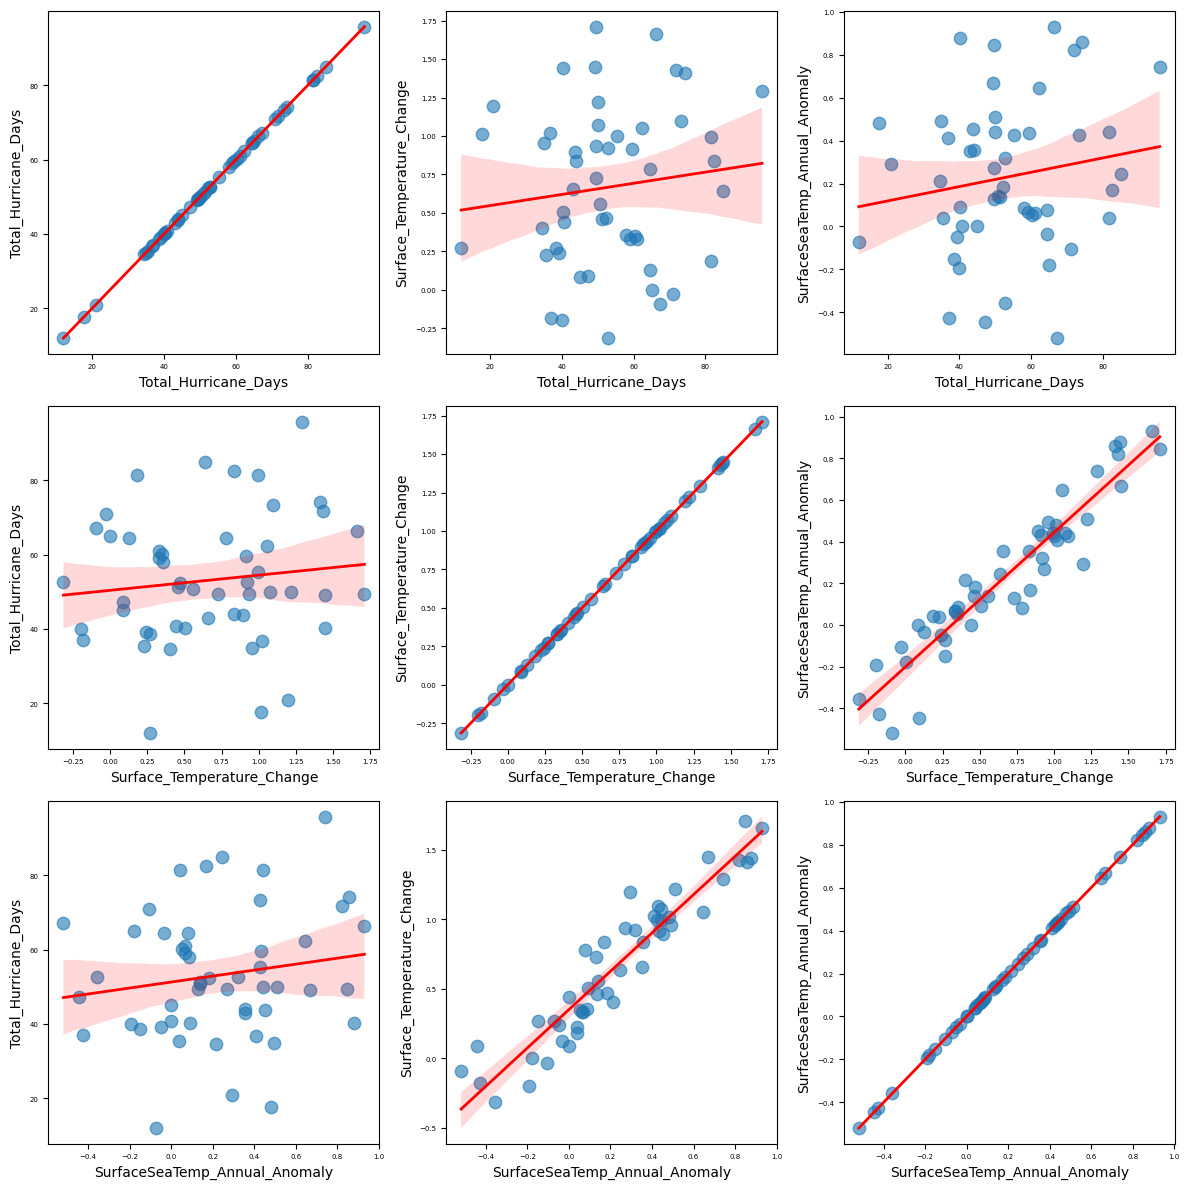

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# makes indexing easier
axes = axes.flatten()

# used for for loop below
variables = ['Total_Hurricane_Days', 'Surface_Temperature_Change', 'SurfaceSeaTemp_Annual_Anomaly']

# selects color palette
palette = sns.color_palette("YlGnBu", as_cmap=True)

# loop through each variable and make scatterplot for each one
plot_idx = 0
for var1 in variables:
    for var2 in variables:
        # adds line of best fit and plot
        sns.regplot(x=var1, y=var2, data=data, ax=axes[plot_idx], scatter_kws={'s': 80, 'alpha': 0.6}, line_kws={'color':"red",'lw': 2})

        # set titles and labels
        axes[plot_idx].set_xlabel(var1, fontsize=10)
        axes[plot_idx].set_ylabel(var2, fontsize=10)

        # remove ticks for clarity
        axes[plot_idx].tick_params(axis='both', which='major', labelsize=5)

        plot_idx += 1

# prevent overlap
plt.tight_layout()

plt.show()

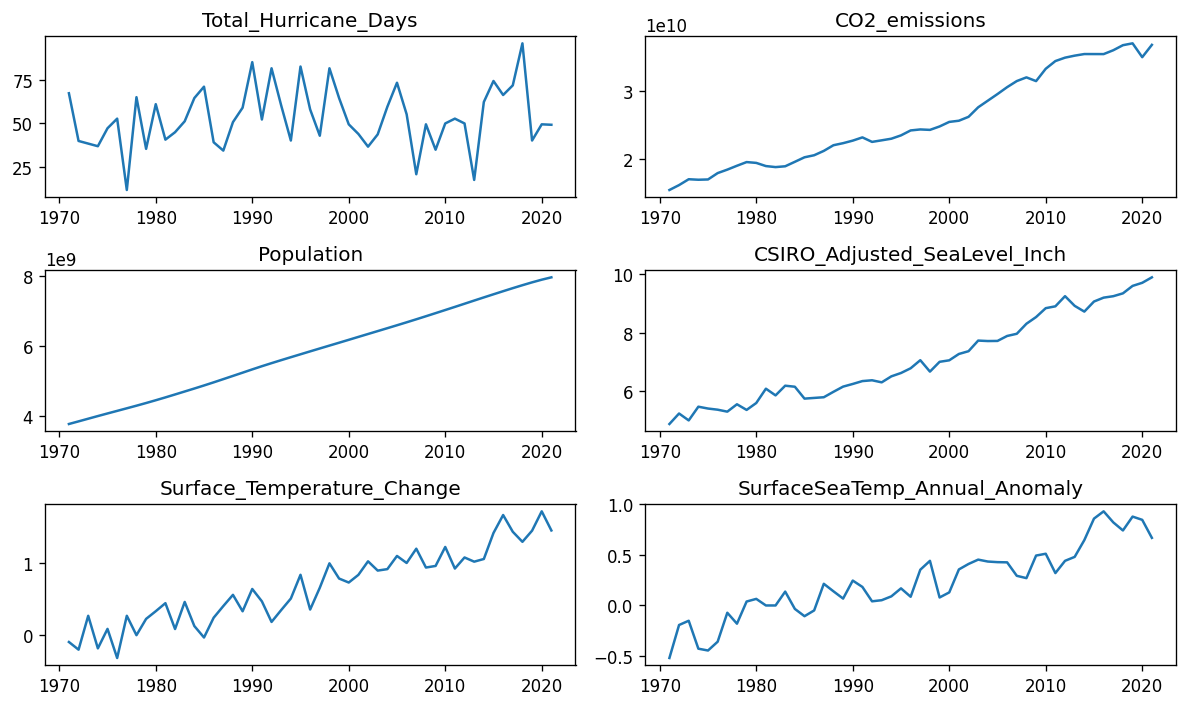

In [8]:
# set up plot structure
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    temp = data[data.columns[i]]
    ax.plot(temp)
    ax.set_title(data.columns[i])

plt.tight_layout();

# Grangers Causality Test
This test tells us if past values of one variables improves predictions of another. When looking at the Total_Hurrricane_Days_Y variable, if the number is statistically significant for all X's (below 0.05), we say that variable X Granger causes variable y. This means our X's are useful in predicting our Y value.

In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=12, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(12)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(data, variables = data.columns)

,Total_Hurricane_Days_x,CO2_emissions_x,Population_x,CSIRO_Adjusted_SeaLevel_Inch_x,Surface_Temperature_Change_x,SurfaceSeaTemp_Annual_Anomaly_x
Total_Hurricane_Days_y,1.0000,0.0244,0.0,0.0000,0.0246,0.0000
CO2_emissions_y,0.0058,1.0000,0.0,0.0003,0.0000,0.0000
Population_y,0.0000,0.0000,1.0,0.0000,0.0000,0.0000
CSIRO_Adjusted_SeaLevel_Inch_y,0.0003,0.0011,0.0,1.0000,0.0008,0.0173
Surface_Temperature_Change_y,0.0404,0.0000,0.0,0.0000,1.0000,0.0000
SurfaceSeaTemp_Annual_Anomaly_y,0.0057,0.0000,0.0,0.0000,0.0000,1.0000


Since the p-value is significant, we know that our X's have predictive power and we can continue with our analysis

# Cointegration Test

Next we will conduct the cointegration test. This is important as it tests for long term relationships between the variables even if the variables are non-stationary, and it is an essential initial test for the VAR model.

In [11]:
def cointegration_test(df, alpha=0.05):
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Total_Hurricane_Days ::  336.89    > 83.9383   =>   True
CO2_emissions ::  136.04    > 60.0627   =>   True
Population ::  83.27     > 40.1749   =>   True
CSIRO_Adjusted_SeaLevel_Inch ::  49.49     > 24.2761   =>   True
Surface_Temperature_Change ::  26.17     > 12.3212   =>   True
SurfaceSeaTemp_Annual_Anomaly ::  10.57     > 4.1296    =>   True


We see that the variables